# Equipment Failure Prediction

*by Marina Villaschi*

This report aims to tackle equipment failure problems on operation of an FPSO vessel.

I'll be answering the following questions, as well as drawing insights and explaining the analysis throughout the nootebook.

1. Calculate how many times the equipment has failed.

2. Categorize equipment failures by setups configurations (preset 1 and preset 2).

3. Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).

4. Create a model using the technique you think is most appropriate and measure its performance.

5. Analyze variable importance.

In [47]:
# !pip install scipy
# !pip install scikit-learn

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

from sklearn.inspection import permutation_importance


## Data exploration

In [48]:
# colors for plots
fail_colors = ["#555555", "#FB5072"]

random_state = 55

df = pd.read_excel("data\O_G_Equipment_Data.xlsx")

dict_fail = {
    True: "fail",
    False: "success",
}

df = df.replace(dict_fail)

In [49]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,success
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,success
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,success
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,success
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,success


In [50]:
df.drop(columns=["Cycle"], inplace=True)

In [51]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=random_state)

print(f"Train set: {df_train.shape}")
print(f"Test set:  {df_test.shape}")

Train set: (640, 9)
Test set:  (160, 9)


In [52]:
target = "Fail"

categorical_cols = [
    "Preset_1", "Preset_2"
]

numerical_cols = [
    "Temperature", "Pressure", "VibrationX",
    "VibrationY", "VibrationZ", "Frequency"
]

Check for missing values:

- No missing values in the dataset

In [53]:
df_train.isnull().sum()

Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

Check the distribution of categorical variables:

In [54]:
def bar_plot(
    figsize, title, data, x, y, xlabel=None, ylabel=None,
    palette=None, subtitle=None, hue=None, hue_title=None,
    legend_loc='best', padding=0, ax=None
):
    """
    Plots a bar plot using seaborn.

    Parâmetros:
        figsize (tuple): figure size (width, height)
        title (str): main title for plot
        data (DataFrame): dataframe with data to plot
        x (str): x axis column
        y (str): y axis column
        xlabel (str, optional): x axis label (default: None)
        ylabel (str, optional): y axis label (default: None)
        palette (str ou lista, optional): color palette for plot elements (default: None)
        subtitle (str, optional): subtitle for plot (default: None)
        hue (str, optional): column to be grouped (default: None)
        hue_title (str, optional): title for group legend (default: None)
        legend_loc (str ou tupla, optional): group legend location (default: 'best')
        padding (float, optional): spacing between label and bar label (default: 0)
        ax (Axes, optional): subplot instance to plot (default: None)
    """

    if ax is None:
        # Cria a figura para o gráfico
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
    else:
        # Usa a subplot fornecida
        fig = ax.get_figure()

    # Título e subtítulo alinhados à direita com ajuste de espaçamento
    fig.suptitle(title, fontsize=14, y=1.03)

    ax.set_title(subtitle, fontsize=10, fontstyle='italic')

    # Gráfico de barras
    ax = sns.barplot(data=data, x=x, y=y, errorbar=None, palette=palette, hue=hue, ax=ax)

    # Rótulos do eixo
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Adiciona rótulos nas barras
    for c in ax.containers:
        ax.bar_label(
            c, fmt=lambda x: f"{x:0.0f}%" if x > 0 else "",
            padding=padding, color="White", fontweight="bold"
        )

    # Adiciona títulos na legenda (hue)
    if hue:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title=hue_title, loc=legend_loc)

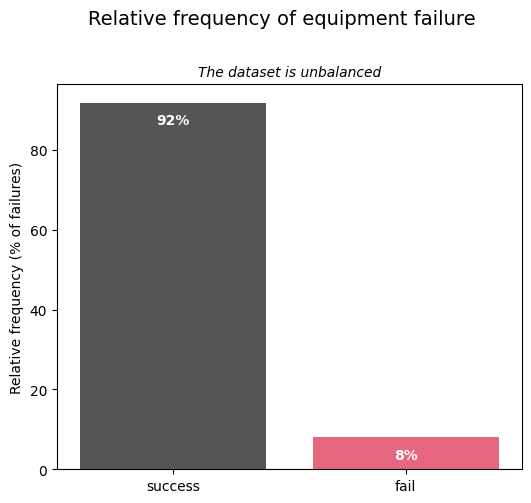

In [55]:
df_freq_fail = df_train['Fail'].value_counts(normalize=True).mul(100).round(2).rename('percent').reset_index()

bar_plot(
    (6, 5),
    'Relative frequency of equipment failure',
    df_freq_fail,
    x = 'Fail',
    y = 'percent',
    ylabel='Relative frequency (% of failures)',
    subtitle='The dataset is unbalanced',
    palette = fail_colors,
    padding=-18
)

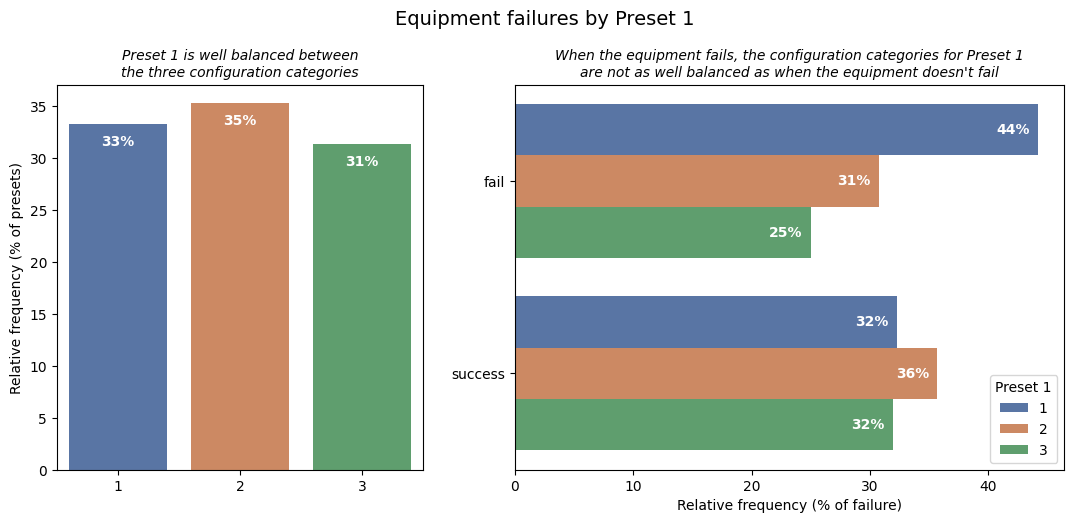

In [56]:
df_freq_preset_1 = df_train["Preset_1"].value_counts(normalize=True).mul(100).round(2).rename("percent").reset_index()

df_by_preset1 = df_train.groupby("Fail")["Preset_1"].value_counts(normalize=True).mul(100).round(2).rename("percent").reset_index()


fig, axes = plt.subplots(1, 2, figsize=(13, 5), width_ratios=[1, 1.5])

bar_plot(
    (6, 5),
    "",
    df_freq_preset_1,
    x = "Preset_1",
    y = "percent",
    ylabel="Relative frequency (% of presets)",
    subtitle="Preset 1 is well balanced between\nthe three configuration categories",
    palette = "deep",
    padding=-18,
    ax=axes[0]
)


bar_plot(
    (8, 5),
    "Equipment failures by Preset 1",
    df_by_preset1,
    y="Fail",
    x="percent",
    xlabel="Relative frequency (% of failure)",
    palette = "deep",
    subtitle = "When the equipment fails, the configuration categories for Preset 1\nare not as well balanced as when the equipment doesn't fail",
    hue="Preset_1",
    hue_title="Preset 1",
    legend_loc="lower right",
    padding=-30,
    ax=axes[1]
)

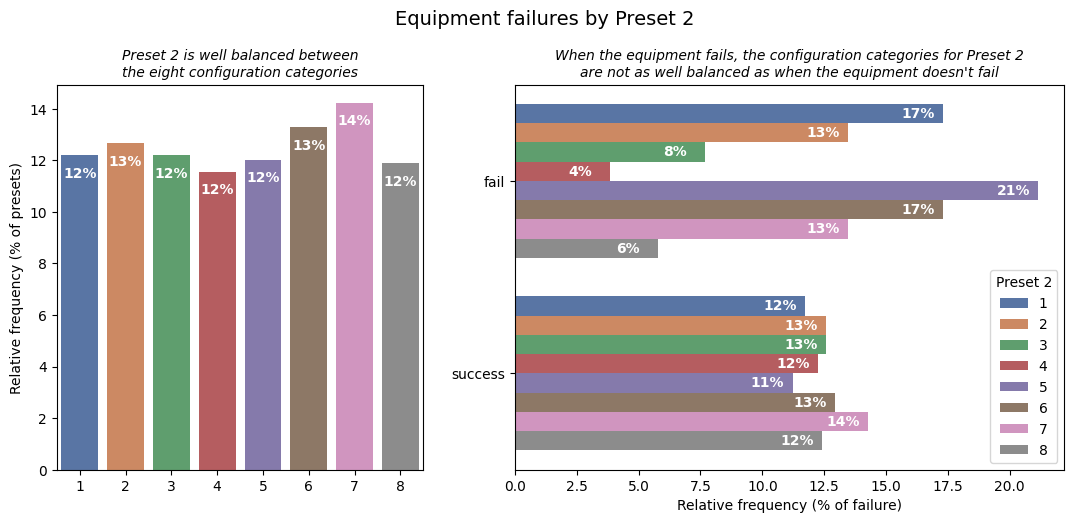

In [57]:
df_freq_preset_2 = df_train["Preset_2"].value_counts(normalize=True).mul(100).round(2).rename("percent").reset_index()

df_by_preset2 = df_train.groupby("Fail")["Preset_2"].value_counts(normalize=True).mul(100).round(2).rename("percent").reset_index()


fig, axes = plt.subplots(1, 2, figsize=(13, 5), width_ratios=[1, 1.5])

bar_plot(
    (6, 5),
    "",
    df_freq_preset_2,
    x = "Preset_2",
    y = "percent",
    ylabel="Relative frequency (% of presets)",
    subtitle="Preset 2 is well balanced between\nthe eight configuration categories",
    palette = "deep",
    padding=-18,
    ax=axes[0]
)


bar_plot(
    (8, 5),
    "Equipment failures by Preset 2",
    df_by_preset2,
    y="Fail",
    x="percent",
    xlabel="Relative frequency (% of failure)",
    palette = "deep",
    subtitle = "When the equipment fails, the configuration categories for Preset 2\nare not as well balanced as when the equipment doesn't fail",
    hue="Preset_2",
    hue_title="Preset 2",
    legend_loc="lower right",
    padding=-30,
    ax=axes[1]
)

Association between target `'Fail'` and independent qualitative features:

- The null hypothesis (H0): *"The features are independent from the target feature"*.

    Using a significance level of 5%, we would **not reject** the null hypothesis, so the features are indeed independent from the target feature.


- The Tschuprow's coefficient measure the degree to which two variables are related. It varies from 0 to 1 where 0 is no association and 1 is perfect association. As we can see, the coefficient is close to 0, meaning no association between the variables.

    These features can be of low importance to the model, we'll dive deeper into this later on.

In [58]:
def chi_sq_test(cross_tabs):
    """
    Prints the Chi-Squared Statistic, p-value, degress of freedom from a Chi-Squared test,
    and Tschuprow coefficient
    
    Args:
        cross_tabs: A crosstab dataframe.
    """
    chi2, p, dof, con_table = stats.chi2_contingency(cross_tabs)
    print(f"chi-squared = {chi2}")
    print(f"p value = {p}")
    print(f"degrees of freedom = {dof}")
    print(f"Tschuprow coefficient = {stats.contingency.association(cross_tabs, method='tschuprow')}\n\n")

# qualitative associations
for var in categorical_cols:
    print(f"-> Feature {var} with target 'Fail'")
    tabs1 = pd.crosstab(df_train["Fail"], df_train[var])
    chi_sq_test(tabs1)

-> Feature Preset_1 with target 'Fail'
chi-squared = 3.109341141262695
p value = 0.2112589660867467
degrees of freedom = 2
Tschuprow coefficient = 0.058612021564601643


-> Feature Preset_2 with target 'Fail'
chi-squared = 11.505055390355801
p value = 0.11805572749016921
degrees of freedom = 7
Tschuprow coefficient = 0.08242896750344542




Check the distribution of continuous variables:

- All continuous variables show a gaussian-like distribution

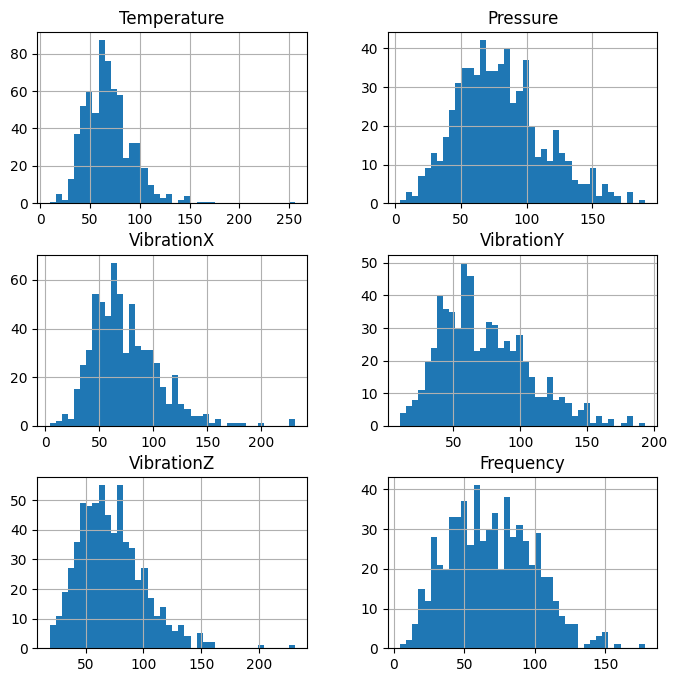

In [59]:
df_train[numerical_cols].hist(bins=40, figsize=(8,8))
plt.show()

Equipment failures by quantitative features:

- There's a noticeable diference in the distribution of all the continuous features (that represent the parameter readings) when the equipment fails.
    
- These features can be of hight importance to the model, we'll dive deeper into this later on.

- There's some ouliers that could get in the way of the model.

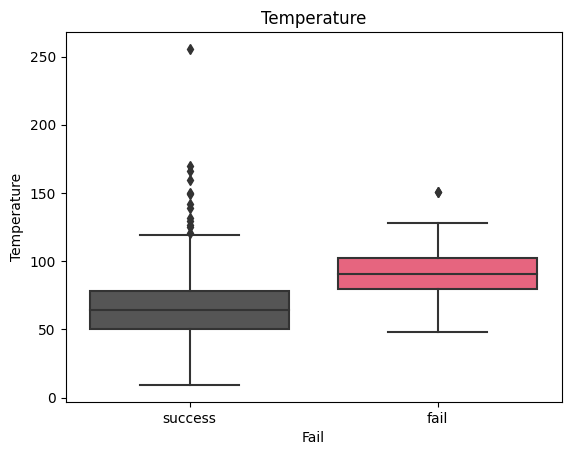

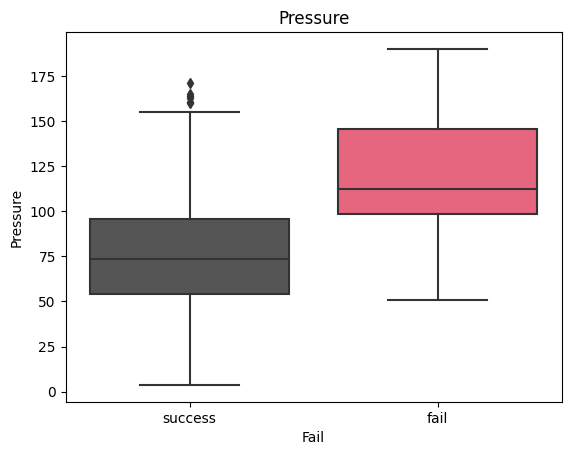

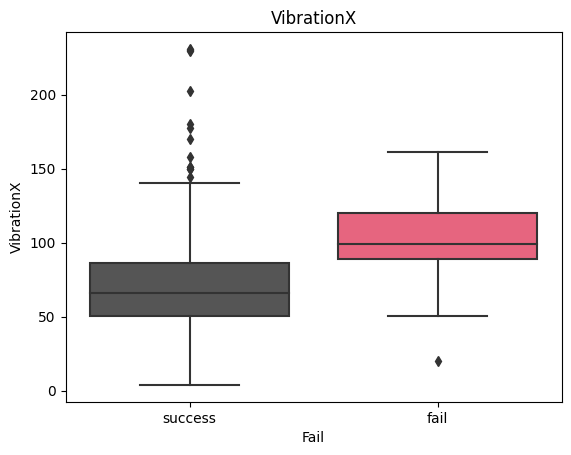

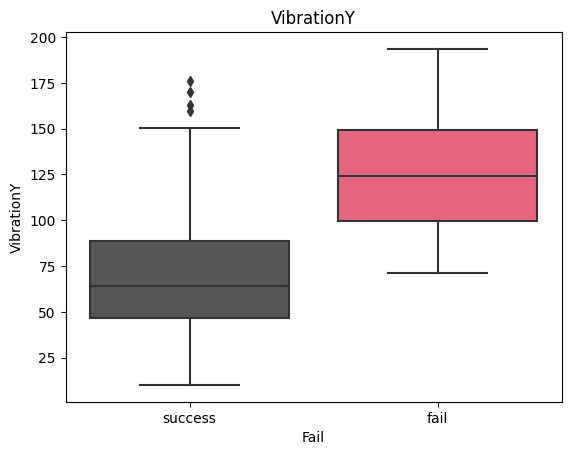

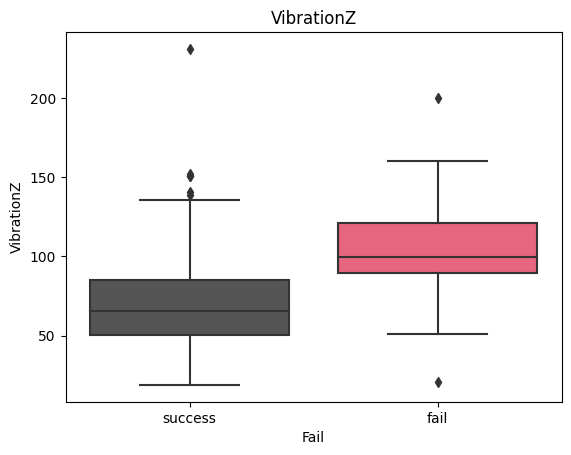

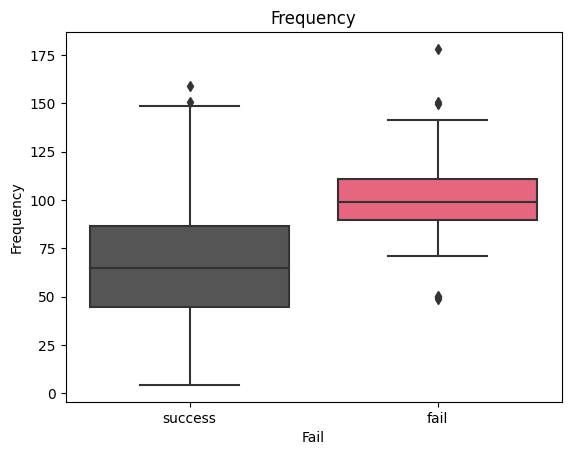

In [60]:
for var in numerical_cols:
    fig, ax = plt.subplots()
    ax1 = sns.boxplot(df_train, x="Fail", y=var, palette=fail_colors)
    ax1.set_title(var)

In [61]:
# Summary measures for quantitative independent features and label to search for relationships
for var in numerical_cols:
    print(var)
    print(df_train.groupby("Fail")[var].agg(["min", "max", "mean", "var", "std"]))
    print("--------------------------------------------------------------------\n")

Temperature
               min         max       mean         var        std
Fail                                                            
fail     48.091962  150.880308  91.488798  532.946807  23.085641
success   9.322154  255.607829  66.782200  560.541031  23.675748
--------------------------------------------------------------------

Pressure
               min         max        mean          var        std
Fail                                                              
fail     50.822002  189.995681  118.015668  1037.291161  32.207005
success   3.729680  170.876875   76.348121   946.063913  30.758152
--------------------------------------------------------------------

VibrationX
               min         max        mean         var        std
Fail                                                             
fail     20.120467  161.188743  101.183409  743.527662  27.267704
success   3.846343  230.861142   71.715461  915.761878  30.261558
------------------------------------

Check the multicolinearity between continuous variables:

 - There's some colinearity between them (Pressure with Temperature, Vibration Z with Vibration X and Y ).


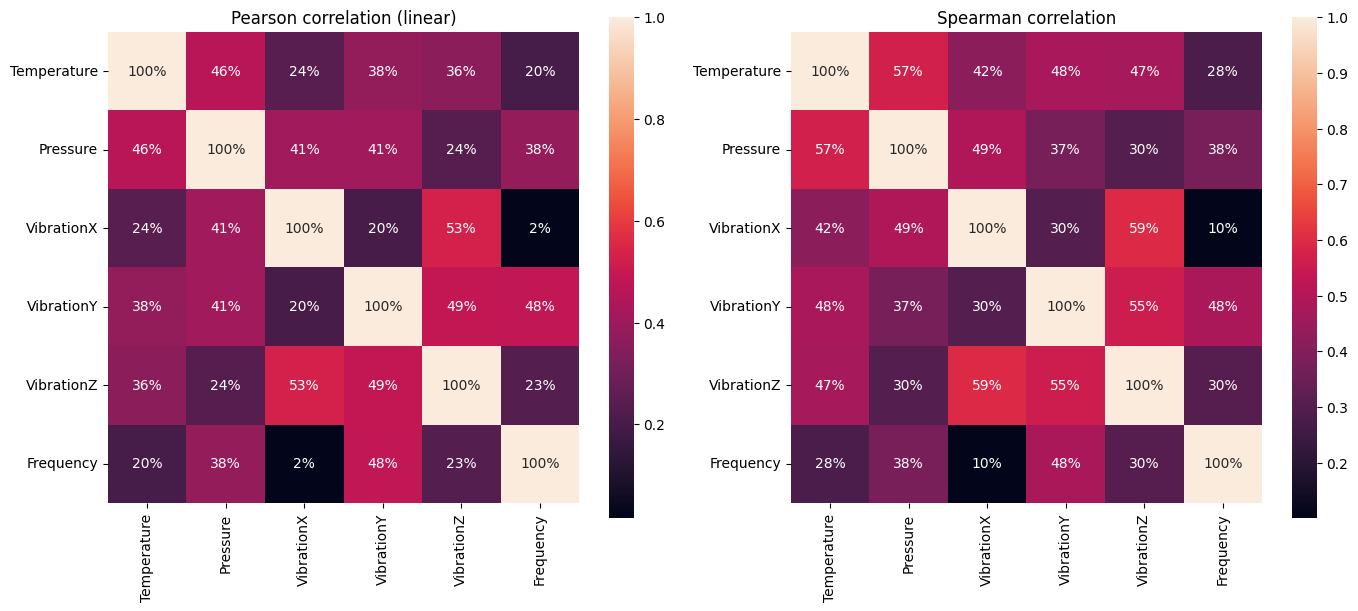

In [62]:
# pearson correlation
pearson_corr = df_train[numerical_cols].corr()
# spearman correlation
spearman_corr = df_train[numerical_cols].corr(method='spearman')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))

sns.heatmap(pearson_corr, fmt='.0%', annot=True, square=True, ax=ax1)
ax1.set_title("Pearson correlation (linear)")

sns.heatmap(spearman_corr, fmt='.0%', annot=True, square=True, ax=ax2)
ax2.set_title("Spearman correlation")

plt.tight_layout()

## Feature Engineering

After testing some feature engineering approaches to get the model to generalize and not overfit, I propose two approaches:

1. Drop variables `Preset_1` and `Preset_2`

2. Drop variables `Preset_1` and `Preset_2`, create feature `VibrationXYZ` (product of `VibrationX`, `VibrationY`, `VibrationZ`) and create feature `Temp_Pressure` (product of `Temperature`, `Pressure`)

Both of them have shown pretty great results on the model, let's take a look.

Let's create the new features and plot their distributions.

In [63]:
# creating datasets for the proposed approaches
df_train2 = df_train.copy()
df_test2 = df_test.copy()

numerical_cols_2 = numerical_cols.copy()

VibrationXYZ
                  min           max          mean           var            std
Fail                                                                          
fail     74489.450928  2.554348e+06  1.331187e+06  2.936653e+11  541908.934366
success   3738.141433  1.762027e+06  3.971142e+05  1.097564e+11  331295.055738


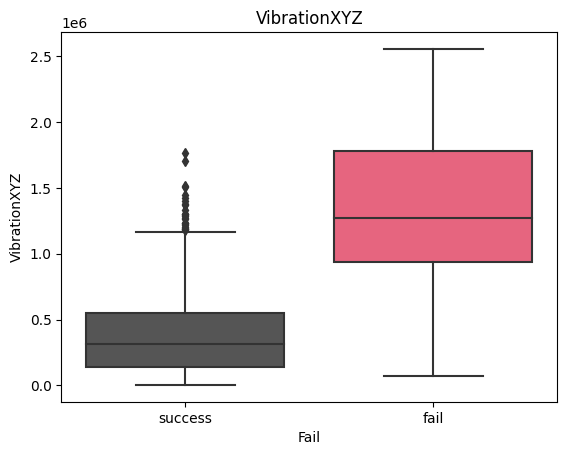

In [64]:
new_col_vibration = "VibrationXYZ"
old_cols_vibration = ["VibrationX", "VibrationY", "VibrationZ"]

df_train2[new_col_vibration] = df_train2[old_cols_vibration[0]] * df_train2[old_cols_vibration[1]] * df_train2[old_cols_vibration[2]]
df_test2[new_col_vibration] = df_test2[old_cols_vibration[0]] * df_test2[old_cols_vibration[1]] * df_test2[old_cols_vibration[2]]

df_train2.drop(columns=old_cols_vibration, inplace=True)
df_test2.drop(columns=old_cols_vibration, inplace=True)

numerical_cols_2 += [new_col_vibration]

for col in old_cols_vibration:
    numerical_cols_2.remove(col)


print(new_col_vibration)
print(df_train2.groupby("Fail")[new_col_vibration].agg(["min", "max", "mean", "var", "std"]))


fig, ax = plt.subplots()
sns.boxplot(df_train2, x="Fail", y=new_col_vibration, palette=fail_colors)
ax.set_title(new_col_vibration)
plt.show()

Temp_Pressure
                 min           max          mean           var          std
Fail                                                                       
fail     3368.306670  20708.904420  10915.903912  1.890168e+07  4347.605825
success   214.377694  23976.505641   5410.484479  1.130779e+07  3362.705136


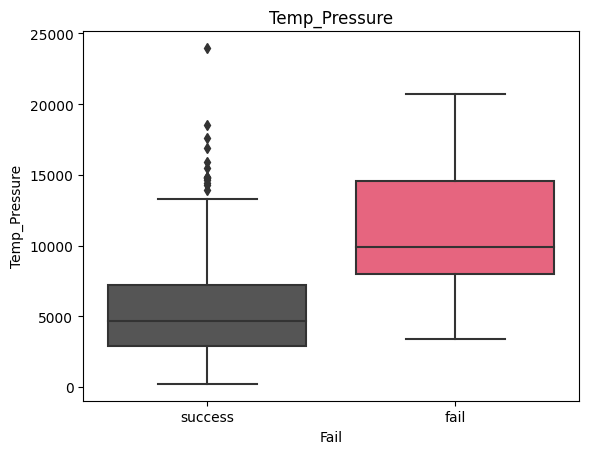

In [65]:
new_col_temp_press = "Temp_Pressure"
old_cols_temp_press = ["Temperature", "Pressure"]

df_train2[new_col_temp_press] = df_train2[old_cols_temp_press[0]] * df_train2[old_cols_temp_press[1]]
df_test2[new_col_temp_press] = df_test2[old_cols_temp_press[0]] * df_test2[old_cols_temp_press[1]]

df_train2.drop(columns=old_cols_temp_press, inplace=True)
df_test2.drop(columns=old_cols_temp_press, inplace=True)

numerical_cols_2 += [new_col_temp_press]

for col in old_cols_temp_press:
    numerical_cols_2.remove(col)


print(new_col_temp_press)
print(df_train2.groupby("Fail")[new_col_temp_press].agg(["min", "max", "mean", "var", "std"]))


fig, ax = plt.subplots()
sns.boxplot(df_train2, x="Fail", y=new_col_temp_press, palette=fail_colors)
ax.set_title(new_col_temp_press)
plt.show()

From now on, we'll go on with two dataframes for the two proposed approaches:

1. *df_train* and *df_test* (removed features `Preset_1` and `Preset_2`)

2. *df_train2* and *df_test2* (removed features `Preset_1` and `Preset_2`, created features `VibrationXYZ` and `Temp_Pressure`)

## Preprocessing

Apply feature scaling preprocessing on the numerical variables:

In [66]:
# changing the target variable to feed the model 
dict_fail_model = {
    "fail": 1,
    "success": 0,
}

df_train = df_train.replace(dict_fail_model)
df_test = df_test.replace(dict_fail_model)

df_train2 = df_train2.replace(dict_fail_model)
df_test2 = df_test2.replace(dict_fail_model)

In [67]:
# creating the feature matrix and target vector
X_train = df_train.drop(columns="Fail")
y_train = df_train["Fail"]

X_train2 = df_train2.drop(columns="Fail")
y_train2 = df_train2["Fail"]

In [68]:
preprocessor = ColumnTransformer(
    [
        ("cat", "drop", categorical_cols),
        ("num", StandardScaler(), numerical_cols),
    ],
    remainder="passthrough"
)

preprocessor2 = ColumnTransformer(
    [
        ("cat", "drop", categorical_cols),
        ("num", StandardScaler(), numerical_cols_2), # numerical columns updated with feature engineering
    ],
    remainder="passthrough"
)

## Model

It's considered best practice in machine learning to make decisions about the model using only the training set and cross-validation set, and to not look at the test set at all.

This ensures that the test set is a fair and not overly optimistic estimate of how well the model will generalize to new data. It should be used only to what it was made for: testing the model on unseen data.

### Evaluation Metric

The evaluation metric should be picked based on the business knowledge.

Accuracy is inappropriate for imbalanced classification problems as we can get a pretty great accuracy score with a simple Dummy Classifier that always predicts the larger class, or that the equipment isn't failing. That wouldn't be very helpful so we need a better metric.

The goal of the model I'm building is to predict whether the FPSO vessel equipment is on the verge of failing based on the sensors measurements over time. With that in mind, the model evaluation metric I'll be using is `recall`. 

Having a higher recall means when in doubt, the model would predict the equipment is failing so we don’t risk missing fixing the equipment that actually is failing. This way, we’re more likely to correctly identify more failures.

It means we can come across some false positives, that is, predict that the equipment is about to fail when it's actually not. In this scenario, it's better to have some false positives than false negatives (when the equipment fails but the model didn't catch it).

We'll be looking at the f1 score as well which is basically the harmonic mean between recall and precision. This way we don't loose track of how much we're hurting precision in order to improve recall.


In [69]:
def run_classifier_models(models_list, X, y, cv, scoring):
    """
    Trains classification models (passed on a list of models) applying cross validation
    with the amount of folds passed on cv and returns a dataframe with all
    the models' mean and standard deviations of the selected scoring method for
    both training and validation sets.
    
    :param models_list: (list) 
    List of instantiated models to train.
    
    :param X: (dataframe or numpy array) 
    Independent variables dataframe.
    
    :param y: (series or numpy array)
    Target vector.
    
    :param cv: (int)
    Amount of folds for the cross validation technique.
    
    :param scoring: (str)
    Score metric to measure model performance on.
    """

    df_models = pd.DataFrame()

    # train and evaluate each one of the models
    for model in models_list:
        pipe = Pipeline(
            [
                ('preprocessor', preprocessor),
                ('classifier', model)
            ]
        )

        scores = cross_validate(
            pipe, X, y, cv=cv, scoring=scoring, return_train_score=True
        )

        mean_train_score = scores['train_score'].mean()
        std_train_score = scores['train_score'].std()

        mean_val_score = scores['test_score'].mean()
        std_val_score = scores['test_score'].std()

        model_dict = {
            'model': type(model).__name__,
            'scoring': scoring,
            'mean_train_score': mean_train_score,
            'mean_val_score': mean_val_score,
            'std_train_score': std_train_score,
            'std_val_score': std_val_score,
        }

        df_temp = pd.DataFrame({k:[v] for k,v in model_dict.items()})
        df_models = pd.concat([df_models, df_temp], ignore_index=True)
        
    return df_models

In [70]:
dummy = DummyClassifier(strategy="constant", constant=0)
lr = LogisticRegression(max_iter=400, random_state=random_state)
dt = DecisionTreeClassifier(random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)
sgd = SGDClassifier(loss='log_loss', penalty='elasticnet', random_state=random_state)
gnb = GaussianNB()
ada = AdaBoostClassifier(random_state=random_state)

models_list = [dummy, lr, rf, dt, sgd, gnb, ada]

In [71]:
df_acc = run_classifier_models(models_list, X_train, y_train, cv=5, scoring='accuracy')
df_acc

,model,scoring,mean_train_score,mean_val_score,std_train_score,std_val_score
0,DummyClassifier,accuracy,0.918750,0.918750,0.000957,0.003827
1,LogisticRegression,accuracy,0.941797,0.935937,0.002278,0.020010
2,RandomForestClassifier,accuracy,1.000000,0.939063,0.000000,0.015934
3,DecisionTreeClassifier,accuracy,1.000000,0.934375,0.000000,0.020131
4,SGDClassifier,accuracy,0.935937,0.939063,0.011614,0.018087
5,GaussianNB,accuracy,0.937109,0.932813,0.007350,0.029064
6,AdaBoostClassifier,accuracy,0.999609,0.942187,0.000781,0.018222


As we stated before, the Dummy classifier does a great job accuracy wise even when it always predicts that the equipment is all good.

On the other hand, it didn't do well even on the train set as far as recall is concerned because as it always predicts the negative class (success), when calculating the recall, the positive class (fail) is the one being counted:

> Recall = TruePositives / (TruePositives + FalseNegatives)

In [72]:
df_recall = run_classifier_models(models_list, X_train, y_train, cv=5, scoring= 'recall')
df_recall

,model,scoring,mean_train_score,mean_val_score,std_train_score,std_val_score
0,DummyClassifier,recall,0.000000,0.000000,0.000000,0.000000
1,LogisticRegression,recall,0.495122,0.478182,0.016200,0.132565
2,RandomForestClassifier,recall,1.000000,0.461818,0.000000,0.112581
3,DecisionTreeClassifier,recall,1.000000,0.634545,0.000000,0.092959
4,SGDClassifier,recall,0.640650,0.610909,0.199739,0.219345
5,GaussianNB,recall,0.841231,0.810909,0.056246,0.164984
6,AdaBoostClassifier,recall,0.995122,0.554545,0.009756,0.154171


In [73]:
df_f1 = run_classifier_models(models_list, X_train, y_train, cv=5, scoring='f1')
df_f1

,model,scoring,mean_train_score,mean_val_score,std_train_score,std_val_score
0,DummyClassifier,f1,0.000000,0.000000,0.000000,0.000000
1,LogisticRegression,f1,0.580170,0.546697,0.018585,0.100105
2,RandomForestClassifier,f1,1.000000,0.550453,0.000000,0.095055
3,DecisionTreeClassifier,f1,1.000000,0.615787,0.000000,0.084788
4,SGDClassifier,f1,0.611916,0.610376,0.034364,0.117101
5,GaussianNB,f1,0.684556,0.670334,0.039058,0.111749
6,AdaBoostClassifier,f1,0.997531,0.604706,0.004938,0.137159


With this first round of models, I picked two of them to move to the next step:

- Decision Tree:

    Both decision tree and random forest show some overfitting as the performance on the train set is perfect and on the validation set isn't nearly as great. We'll move forward with decision tree over random forest as it's a simpler model and has greater explainability. We can work on tunning it to prevent overfitting.

- SGD Classifier:

    The model didn't do so well on the train set, but it shows similar performance on the validation set indicating it's not overfitting and we can work on improving the model. This model is somewhat similar to the classic logistic regression with stochastic gradient descent learning and the power of regularization (adding penalty to the loss function to avoid overfitting).


### Tunning chosen models

In [74]:
def build_pipeline(model, preprocessor):
    final_pipe = Pipeline(
        [
            ('preprocessor', preprocessor), 
            ('classifier', model)
        ]
    )
    return final_pipe


def train_grid_search(pipeline, X, y, paramgrid, cv, scoring):

    print(type(pipeline[-1]).__name__)
    
    grid_search = GridSearchCV(
        pipeline, paramgrid, cv=cv, scoring=scoring, return_train_score=True, verbose=1, n_jobs=2
    )

    grid_result = grid_search.fit(X, y)

    print(f"\nBest score: {grid_result.best_score_} using parameters:\n{grid_result.best_params_}\n")

    return grid_result

First round - with approach 1:
- DecisionTree (df_train)

In [75]:
%%time

final_pipe_dt = build_pipeline(dt, preprocessor)

# hyperparameter interval to be tested
paramgrid_dt = {
    'classifier__max_depth': [None, 3, 5, 10, 15, 20, 50],
    'classifier__class_weight': [{0:1, 1:1}, {0:1, 1:10}, {0:1, 1:100}, {0:1, 1:300}]
}

cv_dt = train_grid_search(final_pipe_dt, X_train, y_train, paramgrid_dt, cv=5, scoring='recall')

DecisionTreeClassifier
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best score: 0.9418181818181818 using parameters:
{'classifier__class_weight': {0: 1, 1: 100}, 'classifier__max_depth': 3}

CPU times: total: 109 ms
Wall time: 2.08 s


- SGDClassifier (df_train)

In [76]:
%%time
final_pipe_sgd = build_pipeline(sgd, preprocessor)

# hyperparameter interval to be tested
paramgrid_sgd = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.05, 0.1, 0.5, 1, 5, 10],
    'classifier__class_weight': [{0:1, 1:1}, {0:1, 1:10}, {0:1, 1:100}, {0:1, 1:300}],
    'classifier__max_iter': [1000, 3000, 5000]
}

cv_sgd = train_grid_search(final_pipe_sgd, X_train, y_train, paramgrid_sgd, cv=5, scoring='recall')

SGDClassifier
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits

Best score: 1.0 using parameters:
{'classifier__class_weight': {0: 1, 1: 10}, 'classifier__eta0': 0.05, 'classifier__learning_rate': 'invscaling', 'classifier__max_iter': 1000, 'classifier__penalty': 'l1'}

CPU times: total: 1.06 s
Wall time: 47.6 s


Second round - with approach 2 (with feature engineering):

- DecisionTree (df_train2)

In [77]:
%%time
final_pipe_dt2 = build_pipeline(dt, preprocessor2)

# hyperparameter interval to be tested
paramgrid_dt = {
    'classifier__max_depth': [None, 3, 5, 10, 15, 20, 50],
    'classifier__class_weight': [{0:1, 1:1}, {0:1, 1:10}, {0:1, 1:100}, {0:1, 1:300}]
}

cv_dt2 = train_grid_search(final_pipe_dt2, X_train2, y_train2, paramgrid_dt, cv=5, scoring='recall')

DecisionTreeClassifier
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best score: 0.9418181818181818 using parameters:
{'classifier__class_weight': {0: 1, 1: 300}, 'classifier__max_depth': 3}

CPU times: total: 46.9 ms
Wall time: 1.04 s


- SGDClassifier (df_train2)

In [78]:
%%time
final_pipe_sgd2 = build_pipeline(sgd, preprocessor2)

# hyperparameter interval to be tested
paramgrid_sgd = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.05, 0.1, 0.5, 1, 5, 10],
    'classifier__class_weight': [{0:1, 1:1}, {0:1, 1:10}, {0:1, 1:100}, {0:1, 1:300}],
    'classifier__max_iter': [1000, 3000, 5000]
}

cv_sgd2 = train_grid_search(final_pipe_sgd2, X_train2, y_train2, paramgrid_sgd, cv=5, scoring='recall')

SGDClassifier
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits

Best score: 1.0 using parameters:
{'classifier__class_weight': {0: 1, 1: 10}, 'classifier__eta0': 10, 'classifier__learning_rate': 'constant', 'classifier__max_iter': 1000, 'classifier__penalty': 'l1'}

CPU times: total: 391 ms
Wall time: 39.2 s


## Evaluate models

In [79]:
X_test = df_test.drop(columns="Fail")
y_test = df_test["Fail"]

X_test2 = df_test2.drop(columns="Fail")
y_test2 = df_test2["Fail"]

First round - with approach 1:
- DecisionTree (df_test)

    The model gerenalizes well, there's only one datapoint (0.071 * 14 = ~1) of the fail class (Fail=True) that the model can't correctly classify. It does a pretty good job regarding false positives, missclassifying only about 20 datapoints (0.14 * 146 = ~20) of the not fail class (Fail=False).

---> DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       146
           1       0.38      0.93      0.54        14

    accuracy                           0.86       160
   macro avg       0.69      0.89      0.73       160
weighted avg       0.94      0.86      0.89       160

AUC: 0.8924



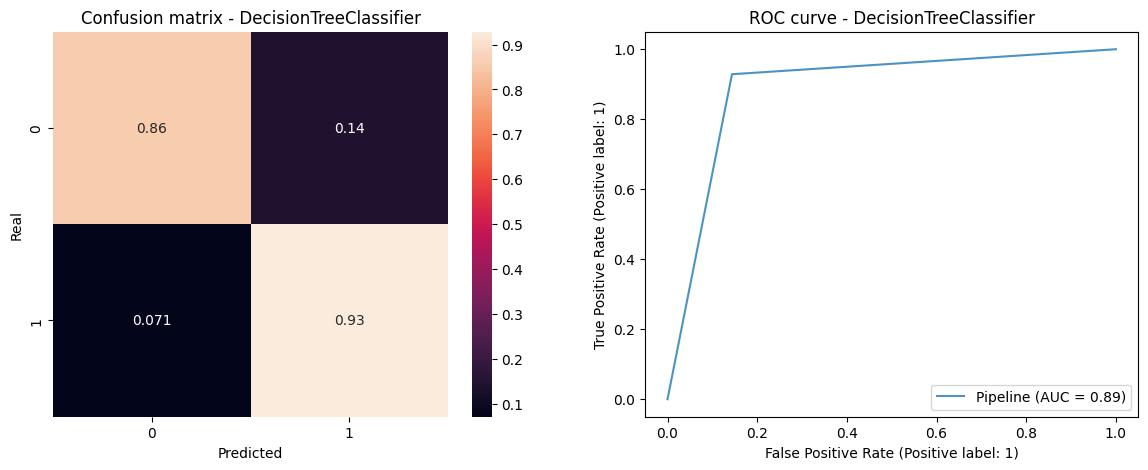

In [80]:
final_model_dt = cv_dt.best_estimator_
final_predictions_dt = final_model_dt.predict(X_test)

# print classification report
print(f"---> {type(final_model_dt[-1]).__name__}")
print(classification_report(y_test, final_predictions_dt))

# print roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, final_predictions_dt)))

# plot confusion matrix and roc_auc
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test, final_predictions_dt, normalize='true'), annot=True, ax=ax1)
ax1.set_title(f"Confusion matrix - {type(final_model_dt[-1]).__name__}")
ax1.set_ylabel("Real")
ax1.set_xlabel("Predicted")

ax2 = plt.gca()
RocCurveDisplay.from_estimator(final_model_dt, X_test, y_test, ax=ax2, alpha=0.8)
ax2.set_title(f"ROC curve - {type(final_model_dt[-1]).__name__}")
plt.show()

- SGDClassifier (df_test)

    The model does an even better job than the one above. It gerenalizes well, correcly classifies all datapoints of the fail class (Fail=True) and it has less false positives, only about 15 (0.1 * 146 = ~15). With that, the f1 score is more balanced.

---> SGDClassifier
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       146
           1       0.48      1.00      0.65        14

    accuracy                           0.91       160
   macro avg       0.74      0.95      0.80       160
weighted avg       0.95      0.91      0.92       160

AUC: 0.9486



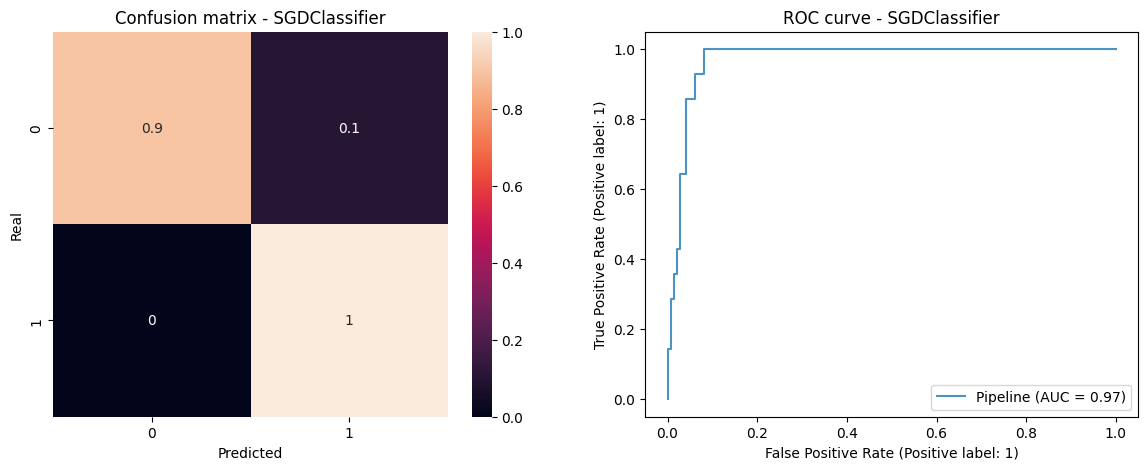

In [81]:
final_model_sgd = cv_sgd.best_estimator_
final_predictions_sgd = final_model_sgd.predict(X_test)

# print classification report
print(f"---> {type(final_model_sgd[-1]).__name__}")
print(classification_report(y_test, final_predictions_sgd))

# print roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, final_predictions_sgd)))

# plot confusion matrix and roc_auc
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test, final_predictions_sgd, normalize='true'), annot=True, ax=ax1)
ax1.set_title(f"Confusion matrix - {type(final_model_sgd[-1]).__name__}")
ax1.set_ylabel("Real")
ax1.set_xlabel("Predicted")

ax2 = plt.gca()
RocCurveDisplay.from_estimator(final_model_sgd, X_test, y_test, ax=ax2, alpha=0.8)
ax2.set_title(f"ROC curve - {type(final_model_sgd[-1]).__name__}")
plt.show()

Second round - with approach 2 (with feature engineering):

- DecisionTree (df_test2)

    With the feature engineerings performed, the tree model did really well on the fail class (Fail=True) not missing a single datapoint. However, in order to do that, it made a lot of mistakes regarding false positives. It missclassified about 66 datapoints (0.45 * 146 = ~66) of the not fail class (Fail=False).

---> DecisionTreeClassifier with feature engineering
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       146
           1       0.18      1.00      0.30        14

    accuracy                           0.59       160
   macro avg       0.59      0.78      0.51       160
weighted avg       0.93      0.59      0.68       160

AUC: 0.7774



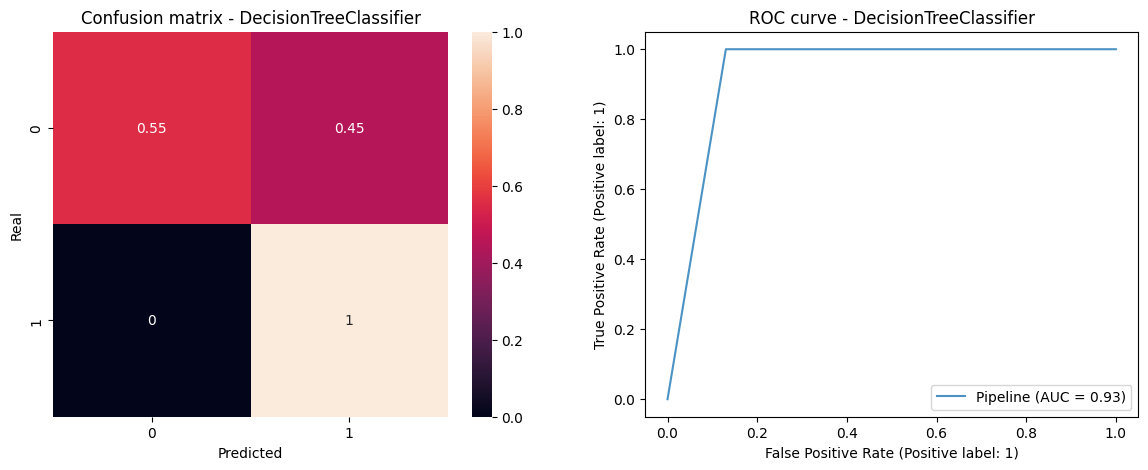

In [82]:
final_model_dt2 = cv_dt2.best_estimator_
final_predictions_dt2 = final_model_dt2.predict(X_test2)

# print classification report
print(f"---> {type(final_model_dt2[-1]).__name__} with feature engineering")
print(classification_report(y_test2, final_predictions_dt2))

# print roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test2, final_predictions_dt2)))

# plot confusion matrix and roc_auc
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test2, final_predictions_dt2, normalize='true'), annot=True, ax=ax1)
ax1.set_title(f"Confusion matrix - {type(final_model_dt2[-1]).__name__}")
ax1.set_ylabel("Real")
ax1.set_xlabel("Predicted")

ax2 = plt.gca()
RocCurveDisplay.from_estimator(final_model_dt2, X_test2, y_test2, ax=ax2, alpha=0.8)
ax2.set_title(f"ROC curve - {type(final_model_dt2[-1]).__name__}")
plt.show()

- SGDClassifier (df_test2)

    On the other hand, the feature engineering performed really worked for the SGD Classifier. It didn't do a perfect job (which is totally normal) on the fail class (Fail=True) missclassifying one datapoint (0.071 * 14 = ~1) but it did much better regarding false positives. It missclassified only 9 datapoints (0.055 * 146 = ~9) making the f1 score much more balanced.

---> SGDClassifier with feature engineering
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       146
           1       0.62      0.93      0.74        14

    accuracy                           0.94       160
   macro avg       0.81      0.94      0.86       160
weighted avg       0.96      0.94      0.95       160

AUC: 0.9369



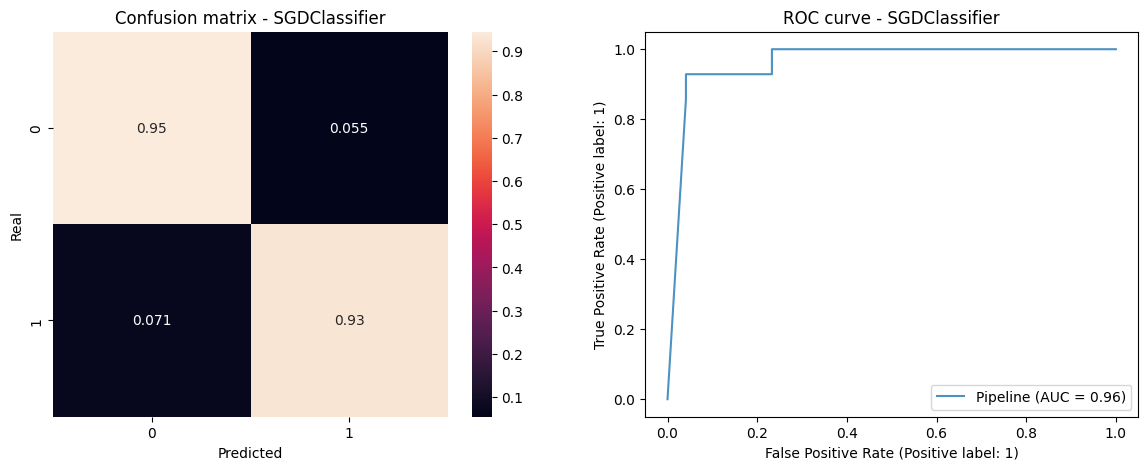

In [83]:
final_model_sgd2 = cv_sgd2.best_estimator_
final_predictions_sgd2 = final_model_sgd2.predict(X_test2)

# print classification report
print(f"---> {type(final_model_sgd2[-1]).__name__} with feature engineering")
print(classification_report(y_test2, final_predictions_sgd2))

# print roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test2, final_predictions_sgd2)))

# plot confusion matrix and roc_auc
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test2, final_predictions_sgd2, normalize='true'), annot=True, ax=ax1)
ax1.set_title(f"Confusion matrix - {type(final_model_sgd2[-1]).__name__}")
ax1.set_ylabel("Real")
ax1.set_xlabel("Predicted")

ax2 = plt.gca()
RocCurveDisplay.from_estimator(final_model_sgd2, X_test2, y_test2, ax=ax2, alpha=0.8)
ax2.set_title(f"ROC curve - {type(final_model_sgd[-1]).__name__}")
plt.show()

## Final models

As explained above, we have:

1. DECISION TREE

    - False negatives = 7%
    
    - False positives = 14%
    

2. SGDCLASSIFIER

    - False negatives = 0

    - False positives = 10%
    
3. DECISION TREE with feature engineering

    - False negatives = 0

    - False positives = 45%


4. SGDCLASSIFIER with feature engineering

    - False negatives = 7%
    
    - False positives = 5.5%


After evaluating its performance on the test set, I would move forward with models 2 and 4, both SGDClassifiers, with and without feature engineering.

Both models 2 and 4 show a good tradeoff between bias and variance, generalizing well and well balanced between recall and precision, that is, false negatives and false positives.

I would gather some more information about the business and bring it to the team as a way of deciding between the models.

### Model interpretation

Regarding models 2 and 4, that are both SGDClassifiers, it's interesting to consider the math behind it as it will help us interpret the model.

When we calculate the exponential of each coeficient, we get the odds ratio.

The odds ratio is the probability of success over probability of not success, in this case, probability of the equipment failing over probability of equipment not failing.

The odds ratio from will indicate how likely the event (fail of the equipment) is to occur when each independent feature changes.

Model 2: SDGClassifier

When we have the variables as they are (without feature engineering), it's mudh easier to interpret the model.

In [84]:
features_names = final_model_sgd[:-1].get_feature_names_out()
coefs = final_model_sgd[-1].coef_
exp_coefs = np.exp(coefs)[0]

for variable, exp_coef in zip(features_names, exp_coefs):
    print(f"As the {variable.split('__')[-1]} increases one unit, the equipment is {round(exp_coef,2)} times more likely to fail.")

As the Temperature increases one unit, the equipment is 1.48 times more likely to fail.
As the Pressure increases one unit, the equipment is 1.61 times more likely to fail.
As the VibrationX increases one unit, the equipment is 1.85 times more likely to fail.
As the VibrationY increases one unit, the equipment is 2.62 times more likely to fail.
As the VibrationZ increases one unit, the equipment is 1.97 times more likely to fail.
As the Frequency increases one unit, the equipment is 2.08 times more likely to fail.


Model4: SGDClassifier with feature engineering

With the feature engineered variables it becomes harder to understand the effect each variable has on the predictions. We exchange feature treaceability for predictive power.

In [85]:
features_names = final_model_sgd2[:-1].get_feature_names_out()
coefs = final_model_sgd2[-1].coef_
exp_coefs = np.exp(coefs)[0]

for variable, exp_coef in zip(features_names, exp_coefs):
    print(f"As the {variable.split('__')[-1]} increases one unit, the equipment is {round(exp_coef,2)} times more likely to fail.")

As the Frequency increases one unit, the equipment is 1.0195636073873138e+122 times more likely to fail.
As the VibrationXYZ increases one unit, the equipment is 2.0500905086382017e+69 times more likely to fail.
As the Temp_Pressure increases one unit, the equipment is 7.643393822844594e+65 times more likely to fail.


### Error analysis

Let's take a look at the datapoints that the final models missclassified:

In [86]:
# sgd model
df_test_pred = df_test.copy()
df_test_pred['final_predictions_sgd'] = final_predictions_sgd

# sgd model with feature engineering
df_test_pred2 = df_test2.copy()
df_test_pred2['final_predictions_sgd2'] = final_predictions_sgd2

SDGClassifier

In [87]:
df_errors_dt = df_test_pred[df_test_pred['Fail'] != df_test_pred['final_predictions_sgd']]
print(df_errors_dt.shape)
df_errors_dt

(15, 10)


,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,final_predictions_sgd
232,2,1,80.124221,185.406401,115.948396,40.246855,105.401973,74.996160,0,1
739,1,2,75.720346,63.913643,66.923618,114.544472,154.690775,74.755959,0,1
87,3,1,96.466297,75.068984,179.928948,129.620299,80.726200,30.222561,0,1
476,2,8,65.561130,136.592852,92.927337,53.344402,96.085591,134.384686,0,1
211,1,7,65.694839,63.346869,59.361535,129.522521,95.159646,109.273036,0,1
249,1,6,75.221692,95.162525,93.948089,94.734066,95.160753,86.253084,0,1
196,2,8,89.756210,97.287972,103.399601,164.432623,110.061636,46.113601,0,1
698,2,5,84.081769,61.200783,66.474525,134.787706,105.306100,98.092270,0,1
267,3,3,101.425593,133.489833,111.238549,95.735918,97.597540,61.513865,0,1
645,1,2,70.269678,93.989705,85.005101,110.009197,94.544989,78.383397,0,1


SGD Classifier with feature engineering

In [88]:
df_errors_sgd2 = df_test_pred2[df_test_pred2['Fail'] != df_test_pred2['final_predictions_sgd2']]
print(df_errors_sgd2.shape)
df_errors_sgd2

(9, 7)


,Preset_1,Preset_2,Frequency,Fail,VibrationXYZ,Temp_Pressure,final_predictions_sgd2
183,2,4,129.210474,0,4.481464e+05,7466.924067,1
414,3,3,50.456673,1,1.013429e+06,8000.916312,0
476,2,8,134.384686,0,4.763110e+05,8955.181689,1
466,2,7,114.326316,0,2.234632e+05,9046.820117,1
267,3,3,61.513865,0,1.039367e+06,13539.285488,1
366,2,5,79.271093,0,1.271036e+06,8455.780895,1
268,1,3,70.681879,0,1.778592e+06,16300.808559,1
409,3,4,121.598046,0,1.400398e+06,14121.178258,1
717,3,4,99.382769,0,1.080653e+06,8422.834178,1


### Feature importance

Feature importance by permutation:

This technique basically shuffles a feature and sees how the model changes its prediction. Thus, the change in prediction will be correspondant to the feature importance.

In [89]:
def permutation_importances(final_model, X, y, scoring, train_or_test):
    result = permutation_importance(
        final_model, X, y, n_repeats=10, random_state=random_state, n_jobs=2, scoring=scoring
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances_ = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )

    ax = importances_.plot.box(vert=False, whis=10)
    ax.set_title(f"{type(final_model[-1]).__name__} - Permutation Importances ({train_or_test} set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in recall score")
    ax.figure.tight_layout()

SGDClassifier

- VibrationY is the most impactful for this model.

- Comparing the feature importances between train and test shows us no significant sign of overfitting as the importance of features were similar.

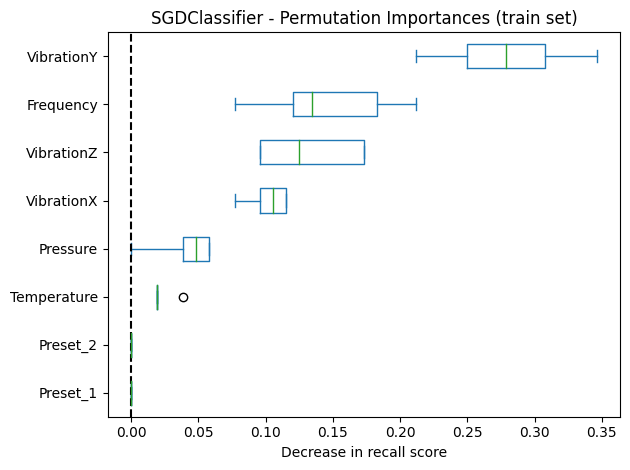

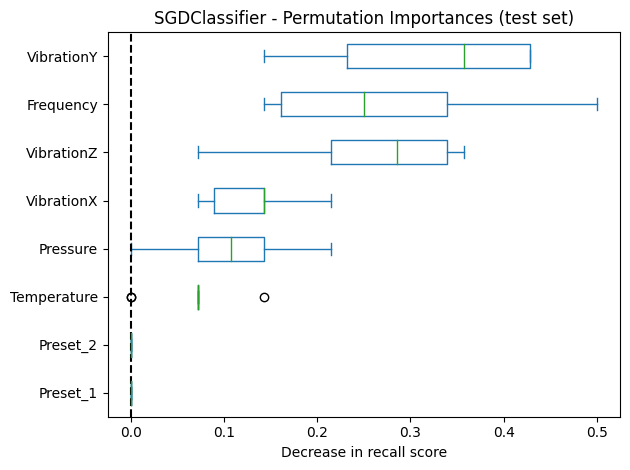

In [90]:
permutation_importances(final_model_sgd, X_train, y_train, scoring='recall', train_or_test='train')
permutation_importances(final_model_sgd, X_test, y_test, scoring='recall', train_or_test='test')

SGDClassifier with feature engineering
 - The three features are very close to each other on importance.

 - There's no significant sign of overfitting when comparing the importance of features on train and test sets.


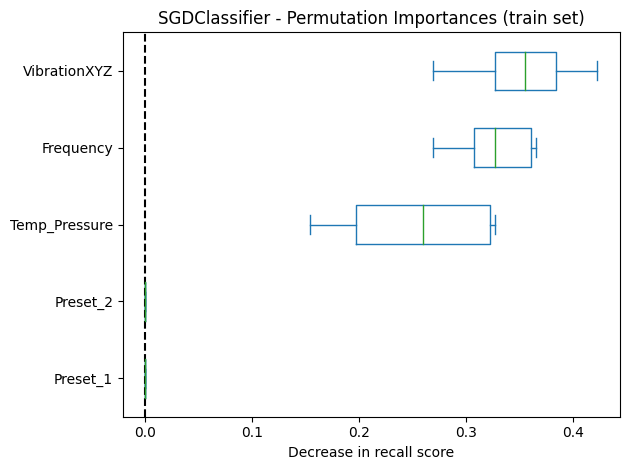

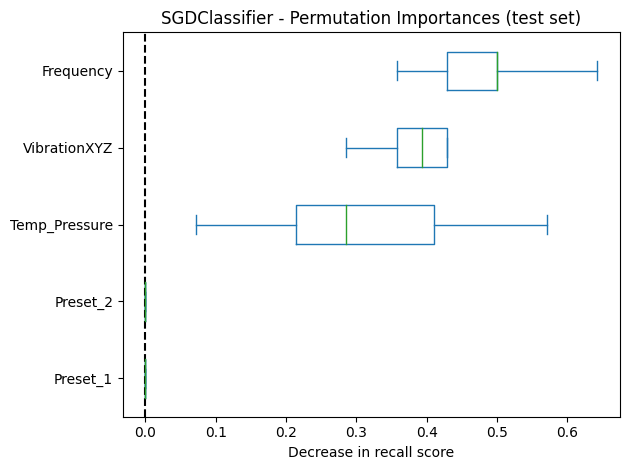

In [91]:
permutation_importances(final_model_sgd2, X_train2, y_train2, scoring='recall', train_or_test='train')
permutation_importances(final_model_sgd2, X_test2, y_test2, scoring='recall', train_or_test='test')

## Next steps

Now it's time to put this model to production. This can be done a few different ways.

Here's a couple of ways I understand can be good for this problem:

- Embedded:

    The trained model can be embedded as a dependency in an application.

    Example: The application that is responsible for measuring the datapoints by the sensors will have the model dependency installed on it and it will call the model module to make the predictions.

    This is a simple approach but once the model needs to be retrained/updated, the entire application would need to be redeployed.

    Latency for predictions: low

- Model API:

    The trained model would be a separate API service that can be requested.

    Example: The application server would make an API request to the dedicated model microservice that returns the prediction.

    This can be done via REST, GRPC or some message broker like Kafka.

    This approach is more complex to implement but it's more flexible when retraining and redeploying is needed because it's a separate service.

    Latency for predictions: moderate

Either way, the machine learning pipeline needs to be reproducible, scalable and make reliable and efficient predictions.

In order to monitor the model in production, we need to collect log data. Monitoring will allow us to understand when data is shifting and the model is becoming less accurate. When that happens, the model can be retrained and updated.
